In [2]:
import pickle
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [388]:
#1단계에서 전처리한 파일 호출
loan = pickle.load( open( "loan_preprocess", "rb" ) )
loan_raw_temp = pickle.load( open( "loan_preprocess", "rb" ) )# 예비파일

### index 정리

In [389]:
loan.reset_index(inplace = True)
loan.tail()

,index,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
270882,270882,887351,36743377,39486112,4200.0,4200.0,4200.0,36 months,15.99,147.64,...,0.0,0.0,0.0,0.0,0.0,0.0,20400.0,0.0,0.0,0.0
270883,270883,887364,36231718,38943165,10775.0,10775.0,10775.0,36 months,6.03,327.95,...,0.0,0.0,0.0,0.0,0.0,0.0,41700.0,0.0,0.0,0.0
270884,270884,887366,36241316,38952731,6225.0,6225.0,6225.0,36 months,16.49,220.37,...,0.0,0.0,0.0,0.0,0.0,0.0,1800.0,0.0,0.0,0.0
270885,270885,887369,36421485,39142898,4000.0,4000.0,4000.0,36 months,8.67,126.59,...,0.0,0.0,0.0,0.0,0.0,0.0,30100.0,0.0,0.0,0.0
270886,270886,887371,36260758,38972123,10850.0,10850.0,10850.0,36 months,19.24,399.04,...,0.0,0.0,0.0,0.0,0.0,0.0,16800.0,0.0,0.0,0.0


In [390]:
print (loan.duplicated('member_id').value_counts())
print (loan.duplicated('id').value_counts())

False    270887
dtype: int64
False    270887
dtype: int64


### id 및 member-id 에 중복값이 없는것을 확인하였으므로, member_id와 기존 index 는 제거한다 

In [391]:
loan.drop('index', axis=1, inplace = True)
loan.drop('member_id', axis=1, inplace = True)
loan.drop('Unnamed: 0', axis=1, inplace = True)
loan.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
270882,36743377,4200.0,4200.0,4200.0,36 months,15.99,147.64,D,D2,supervisor,...,0.0,0.0,0.0,0.0,0.0,0.0,20400.0,0.0,0.0,0.0
270883,36231718,10775.0,10775.0,10775.0,36 months,6.03,327.95,A,A1,Coordinator of RSVP,...,0.0,0.0,0.0,0.0,0.0,0.0,41700.0,0.0,0.0,0.0
270884,36241316,6225.0,6225.0,6225.0,36 months,16.49,220.37,D,D3,Painter,...,0.0,0.0,0.0,0.0,0.0,0.0,1800.0,0.0,0.0,0.0
270885,36421485,4000.0,4000.0,4000.0,36 months,8.67,126.59,B,B1,Lead Custodian,...,0.0,0.0,0.0,0.0,0.0,0.0,30100.0,0.0,0.0,0.0
270886,36260758,10850.0,10850.0,10850.0,36 months,19.24,399.04,E,E2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,16800.0,0.0,0.0,0.0


# Check proportion of y

In [392]:
loan.loan_status.value_counts()

0    209711
1     61176
Name: loan_status, dtype: int64

In [393]:
loan_check = loan.groupby(['loan_status']).size()
loan_check = pd.DataFrame(loan_check)
loan_check_sum = loan_check.agg('sum')
loan_check['proportion'] = loan_check / loan_check_sum
loan_check['loan_status'] = loan_check.index

 # 상환: 0 (77.42%) / 연체: 1 (22.58)
loan_check

,0,proportion,loan_status
loan_status,,,
0,209711,0.774164,0
1,61176,0.225836,1


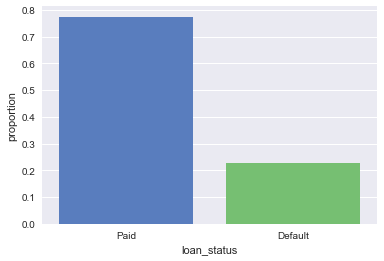

In [394]:
# Visualize

sns.set_style("darkgrid")
bar_plot = sns.barplot(x=loan_check['loan_status'],y=loan_check['proportion'],
                        palette="muted",
                        )
plt.xticks(np.arange(2), ('Paid', 'Default') )
plt.show()

In [395]:
del loan_check, loan_check_sum
gc.collect()


47

# 1. Categorical Featrues

## 1-1) term

In [396]:
print (loan.term.value_counts())

loan_check = loan.groupby(['term', 'loan_status']).size()
loan_check = pd.DataFrame(loan_check)
loan_check.reset_index(inplace=True)
loan_check.rename(columns={0:'count'}, inplace=True)
loan_check.tail()

 36 months    208320
 60 months     62567
Name: term, dtype: int64


,term,loan_status,count
0,36 months,0,169364
1,36 months,1,38956
2,60 months,0,40347
3,60 months,1,22220


In [397]:
loan_check = loan_check.pivot('term', 'loan_status','count')
loan_check = loan_check.reset_index()
loan_check.rename (columns = {0:'paid', 1:'default'}, inplace = True)
loan_check

loan_status,term,paid,default
0,36 months,169364,38956
1,60 months,40347,22220


In [398]:
loan_check['term_pro'] = loan_check.paid / (loan_check.paid + loan_check.default)
loan_check

loan_status,term,paid,default,term_pro
0,36 months,169364,38956,0.812999
1,60 months,40347,22220,0.644861


In [399]:
# one-hot-encoding
loan_check= pd.get_dummies(loan['term'], prefix='term')
loan = loan.join(loan_check)
loan.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,term_ 36 months,term_ 60 months
270882,36743377,4200.0,4200.0,4200.0,36 months,15.99,147.64,D,D2,supervisor,...,0.0,0.0,0.0,0.0,20400.0,0.0,0.0,0.0,1,0
270883,36231718,10775.0,10775.0,10775.0,36 months,6.03,327.95,A,A1,Coordinator of RSVP,...,0.0,0.0,0.0,0.0,41700.0,0.0,0.0,0.0,1,0
270884,36241316,6225.0,6225.0,6225.0,36 months,16.49,220.37,D,D3,Painter,...,0.0,0.0,0.0,0.0,1800.0,0.0,0.0,0.0,1,0
270885,36421485,4000.0,4000.0,4000.0,36 months,8.67,126.59,B,B1,Lead Custodian,...,0.0,0.0,0.0,0.0,30100.0,0.0,0.0,0.0,1,0
270886,36260758,10850.0,10850.0,10850.0,36 months,19.24,399.04,E,E2,0,...,0.0,0.0,0.0,0.0,16800.0,0.0,0.0,0.0,1,0


In [400]:

loan_desc_list = loan['term'].tolist()  # 최초 신용거래 시작일


for i in range(0, len(loan_desc_list)):

    if loan_desc_list[i] == ' 36 months':
        loan_desc_list[i] = 0.813
    elif loan_desc_list[i] == ' 60 months':
        loan_desc_list[i] = 0.645

        
loan['term'] = loan_desc_list    


loan.head()



,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,term_ 36 months,term_ 60 months
0,1077501,5000.0,5000.0,4975.0,0.813,10.65,162.87,B,B2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,1077430,2500.0,2500.0,2500.0,0.645,15.27,59.83,C,C4,Ryder,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,1077175,2400.0,2400.0,2400.0,0.813,15.96,84.33,C,C5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,1076863,10000.0,10000.0,10000.0,0.813,13.49,339.31,C,C1,AIR RESOURCES BOARD,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,1075269,5000.0,5000.0,5000.0,0.813,7.90,156.46,A,A4,Veolia Transportaton,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [401]:

loan.term.value_counts()

0.813    208320
0.645     62567
Name: term, dtype: int64

In [402]:
del loan_check
gc.collect()

296

## 1-2) grade & subgrade
* 상환된 비율을 계산하여 가중치로 값을 바꾼다

In [403]:
print (loan.grade.value_counts())
print (loan.sub_grade.value_counts())

B    79031
C    70326
D    44968
A    43067
E    22143
F     8909
G     2443
Name: grade, dtype: int64
B3    18650
B4    17699
C1    15880
C2    15339
B2    15134
B5    15074
C3    13798
C4    13134
B1    12474
A5    12332
C5    12175
A4    11230
D1    11047
D2     9979
D3     8796
D4     8297
A3     7285
D5     6849
A2     6301
A1     5919
E1     5434
E2     5234
E3     4381
E4     3831
E5     3263
F1     2607
F2     2043
F3     1776
F4     1377
F5     1106
G1      827
G2      605
G3      420
G4      307
G5      284
Name: sub_grade, dtype: int64


In [404]:

loan_check = pd.DataFrame(loan.groupby(['grade', 'sub_grade', 'loan_status']).size())
loan_check = loan_check.reset_index()
loan_check = loan_check.pivot('sub_grade', 'loan_status', 0)
#loan_check['percentage'] = loan_check['1'] / loan_check.sum()
loan_check.reset_index(inplace = True)
loan_check.rename(columns={1:'default', 0: 'paid'}, inplace=True)
loan_check.head()

loan_status,sub_grade,paid,default
0,A1,5692,227
1,A2,5934,367
2,A3,6787,498
3,A4,10298,932
4,A5,11058,1274


In [405]:
loan_check['grade_percentage'] = loan_check.paid / (loan_check.default + loan_check.paid)
loan_check.tail()# 각 sub_grade별 상환 비율

loan_status,sub_grade,paid,default,grade_percentage
30,G1,420,407,0.507860
31,G2,316,289,0.522314
32,G3,210,210,0.500000
33,G4,181,126,0.589577
34,G5,141,143,0.496479


In [406]:
# sub_grade의 값을 비율로 변환
loan['sub_grade'] = loan['sub_grade'].replace({'A1':loan_check['grade_percentage'][loan_check.sub_grade =='A1'].values,
                                              'A2':loan_check['grade_percentage'][loan_check.sub_grade =='A2'].values,
                                              'A3':loan_check['grade_percentage'][loan_check.sub_grade =='A3'].values,
                                              'A4':loan_check['grade_percentage'][loan_check.sub_grade =='A4'].values,
                                              'A5':loan_check['grade_percentage'][loan_check.sub_grade =='A5'].values,
                                              'B1':loan_check['grade_percentage'][loan_check.sub_grade =='B1'].values,
                                              'B2':loan_check['grade_percentage'][loan_check.sub_grade =='B2'].values,
                                              'B3':loan_check['grade_percentage'][loan_check.sub_grade =='B3'].values,
                                              'B4':loan_check['grade_percentage'][loan_check.sub_grade =='B4'].values,
                                              'B5':loan_check['grade_percentage'][loan_check.sub_grade =='B5'].values,
                                              'C1':loan_check['grade_percentage'][loan_check.sub_grade =='C1'].values,
                                              'C2':loan_check['grade_percentage'][loan_check.sub_grade =='C2'].values,
                                              'C3':loan_check['grade_percentage'][loan_check.sub_grade =='C3'].values,
                                              'C4':loan_check['grade_percentage'][loan_check.sub_grade =='C4'].values,
                                              'C5':loan_check['grade_percentage'][loan_check.sub_grade =='C5'].values,
                                              'D1':loan_check['grade_percentage'][loan_check.sub_grade =='D1'].values,
                                              'D2':loan_check['grade_percentage'][loan_check.sub_grade =='D2'].values,
                                              'D3':loan_check['grade_percentage'][loan_check.sub_grade =='D3'].values,
                                              'D4':loan_check['grade_percentage'][loan_check.sub_grade =='D4'].values,
                                              'D5':loan_check['grade_percentage'][loan_check.sub_grade =='D5'].values,
                                              'E1':loan_check['grade_percentage'][loan_check.sub_grade =='E1'].values,
                                              'E2':loan_check['grade_percentage'][loan_check.sub_grade =='E2'].values,
                                              'E3':loan_check['grade_percentage'][loan_check.sub_grade =='E3'].values,
                                              'E4':loan_check['grade_percentage'][loan_check.sub_grade =='E4'].values,
                                              'E5':loan_check['grade_percentage'][loan_check.sub_grade =='E5'].values,
                                              'F1':loan_check['grade_percentage'][loan_check.sub_grade =='F1'].values,
                                              'F2':loan_check['grade_percentage'][loan_check.sub_grade =='F2'].values,
                                              'F3':loan_check['grade_percentage'][loan_check.sub_grade =='F3'].values,
                                              'F4':loan_check['grade_percentage'][loan_check.sub_grade =='F4'].values,
                                              'F5':loan_check['grade_percentage'][loan_check.sub_grade =='F5'].values,
                                              'G1':loan_check['grade_percentage'][loan_check.sub_grade =='G1'].values,
                                              'G2':loan_check['grade_percentage'][loan_check.sub_grade =='G2'].values,
                                              'G3':loan_check['grade_percentage'][loan_check.sub_grade =='G3'].values,
                                              'G4':loan_check['grade_percentage'][loan_check.sub_grade =='G4'].values,
                                              'G5':loan_check['grade_percentage'][loan_check.sub_grade =='G5'].values})


In [407]:
loan.rename(columns={'sub_grade':'grade_score'}, inplace=True)

In [408]:
#주요 등급에 따라 상환 비율을 구하고, 세부 등급의 상환 비율 평균과 어떻게 차이가 나는지 확인 해 본다
loan_check2 = loan[['grade', 'loan_status']]
loan_check2 = pd.DataFrame(loan_check2.groupby(['grade', 'loan_status']).size())

loan_check2 = loan_check2.reset_index().pivot('grade', 'loan_status', 0).reset_index().rename(columns = {0:'paid', 1:'default'})

In [409]:
loan_check2['proportion'] = loan_check2.paid / (loan_check2.paid + loan_check2.default)
loan_check2


loan_status,grade,paid,default,proportion
0,A,39769,3298,0.923422
1,B,66815,12216,0.845428
2,C,53159,17167,0.755894
3,D,30514,14454,0.678571
4,E,13306,8837,0.600912
5,F,4880,4029,0.547761
6,G,1268,1175,0.519034


In [410]:
print ('Proportion of Paid for A1 ~ A5: {:.3f}'.format(loan_check.grade_percentage[:5].mean()))
print ('Proportion of Paid for B1 ~ B5: {:.3f}'.format(loan_check.grade_percentage[5:10].mean()))
print ('Proportion of Paid for C1 ~ C5: {:.3f}'.format(loan_check.grade_percentage[10:15].mean()))
print ('Proportion of Paid for D1 ~ D5: {:.3f}'.format(loan_check.grade_percentage[15:20].mean()))
print ('Proportion of Paid for E1 ~ E5: {:.3f}'.format(loan_check.grade_percentage[20:25].mean()))
print ('Proportion of Paid for F1 ~ F5: {:.3f}'.format(loan_check.grade_percentage[25:30].mean()))
print ('Proportion of Paid for G1 ~ G5: {:.3f}'.format(loan_check.grade_percentage[30:35].mean()))

Proportion of Paid for A1 ~ A5: 0.930
Proportion of Paid for B1 ~ B5: 0.847
Proportion of Paid for C1 ~ C5: 0.753
Proportion of Paid for D1 ~ D5: 0.675
Proportion of Paid for E1 ~ E5: 0.598
Proportion of Paid for F1 ~ F5: 0.540
Proportion of Paid for G1 ~ G5: 0.523


전체 등급이나 세분화된 점수나 비슷함을 알 수 있다

In [411]:
# 전체 등급의 값을 대입하고 산포도를 그려본다
loan['grade'] = loan['grade'].replace({'A' : loan_check2['proportion'][loan_check2.grade=='A'].values,
                                      'B' : loan_check2['proportion'][loan_check2.grade=='B'].values,
                                      'C' : loan_check2['proportion'][loan_check2.grade=='C'].values,
                                      'D' : loan_check2['proportion'][loan_check2.grade=='D'].values,
                                      'E' : loan_check2['proportion'][loan_check2.grade=='E'].values,
                                      'F' : loan_check2['proportion'][loan_check2.grade=='F'].values,
                                      'G' : loan_check2['proportion'][loan_check2.grade=='G'].values,})

In [412]:
# 좀 더 가중치를 주기 위해 grade점수에 제곱한 column을 생성
loan_check = loan[['grade', 'grade_score', 'loan_status']]
loan_check['square'] = loan_check.grade **2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


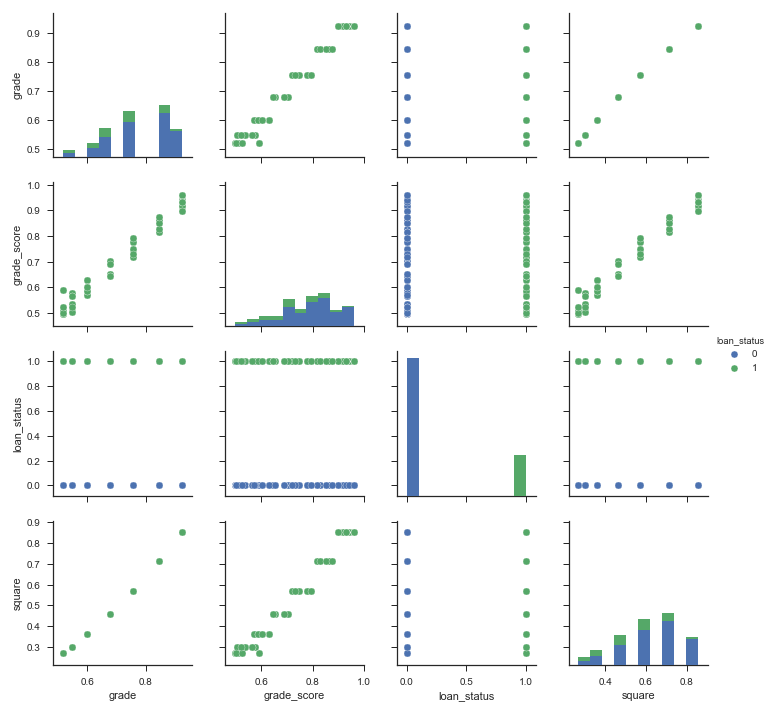

In [413]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True) #matplotlib에 기반한 시각화



sns.pairplot(data=loan_check,
             hue="loan_status", dropna=True)

plt.show()

In [414]:
loan['grade_square'] = loan_check['square']

In [415]:
#grade는 삭제, sub_grade는 변수 이름 변경


print (loan.grade_score.isnull().value_counts())

False    270887
Name: grade_score, dtype: int64


In [416]:
del loan_check
gc.collect()

96434

## 1-3) home_ownership

In [417]:
loan.home_ownership.value_counts()

MORTGAGE    132718
RENT        114187
OWN          23754
OTHER          179
NONE            48
ANY              1
Name: home_ownership, dtype: int64

In [418]:
# one-hot-encoding
loan_check= pd.get_dummies(loan['home_ownership'], prefix='home')
loan = loan.join(loan_check)
loan.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,inq_last_12m,term_ 36 months,term_ 60 months,grade_square,home_ANY,home_MORTGAGE,home_NONE,home_OTHER,home_OWN,home_RENT
270882,36743377,4200.0,4200.0,4200.0,0.813,15.99,147.64,0.678571,0.688546,supervisor,...,0.0,1,0,0.460459,0,1,0,0,0,0
270883,36231718,10775.0,10775.0,10775.0,0.813,6.03,327.95,0.923422,0.961649,Coordinator of RSVP,...,0.0,1,0,0.852708,0,0,0,0,0,1
270884,36241316,6225.0,6225.0,6225.0,0.813,16.49,220.37,0.678571,0.688722,Painter,...,0.0,1,0,0.460459,0,0,0,0,0,1
270885,36421485,4000.0,4000.0,4000.0,0.813,8.67,126.59,0.845428,0.875421,Lead Custodian,...,0.0,1,0,0.714748,0,1,0,0,0,0
270886,36260758,10850.0,10850.0,10850.0,0.813,19.24,399.04,0.600912,0.601834,0,...,0.0,1,0,0.361096,0,0,0,0,1,0


In [419]:
# 주거 형태에 따른 상환 비율을 파악 해 본다
loan_check = loan[['home_ownership', 'loan_status']]
loan_check = pd.DataFrame(loan_check.groupby(['home_ownership', 'loan_status']).\
                          size()).reset_index().pivot('home_ownership', 'loan_status', 0)
loan_check = loan_check.reset_index().rename(columns = {0:'paid', 1:'default'}).fillna(0)
loan_check['home_score'] = loan_check.paid / (loan_check.paid + loan_check.default)
loan_check

loan_status,home_ownership,paid,default,home_score
0,ANY,1.0,0.0,1.000000
1,MORTGAGE,105874.0,26844.0,0.797737
2,NONE,40.0,8.0,0.833333
3,OTHER,141.0,38.0,0.787709
4,OWN,18098.0,5656.0,0.761893
5,RENT,85557.0,28630.0,0.749271


In [420]:

loan_desc_list = loan['home_ownership'].tolist()  # 최초 신용거래 시작일


for i in range(0, len(loan_desc_list)):

    if loan_desc_list[i] == 'ANY':
        loan_desc_list[i] = loan_check['home_score'][0]
    elif loan_desc_list[i] == 'MORTGAGE':
        loan_desc_list[i] = loan_check['home_score'][1]
    elif loan_desc_list[i] == 'NONE':
        loan_desc_list[i] = loan_check['home_score'][2]
    elif loan_desc_list[i] == 'OTHER':
        loan_desc_list[i] = loan_check['home_score'][3]
    elif loan_desc_list[i] == 'OWN':
        loan_desc_list[i] = loan_check['home_score'][4]
    elif loan_desc_list[i] == 'RENT':
        loan_desc_list[i] = loan_check['home_score'][5]

loan['home_score'] = loan_desc_list    

loan.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,term_ 36 months,term_ 60 months,grade_square,home_ANY,home_MORTGAGE,home_NONE,home_OTHER,home_OWN,home_RENT,home_score
0,1077501,5000.0,5000.0,4975.0,0.813,10.65,162.87,0.845428,0.864213,0,...,1,0,0.714748,0,0,0,0,0,1,0.749271
1,1077430,2500.0,2500.0,2500.0,0.645,15.27,59.83,0.755894,0.730623,Ryder,...,0,1,0.571376,0,0,0,0,0,1,0.749271
2,1077175,2400.0,2400.0,2400.0,0.813,15.96,84.33,0.755894,0.718686,0,...,1,0,0.571376,0,0,0,0,0,1,0.749271
3,1076863,10000.0,10000.0,10000.0,0.813,13.49,339.31,0.755894,0.791940,AIR RESOURCES BOARD,...,1,0,0.571376,0,0,0,0,0,1,0.749271
4,1075269,5000.0,5000.0,5000.0,0.813,7.90,156.46,0.923422,0.917008,Veolia Transportaton,...,1,0,0.852708,0,0,0,0,0,1,0.749271


In [421]:
loan.drop('home_ownership', axis = 1, inplace = True)

## 1-4) emp_length

In [422]:
loan.emp_length.value_counts()

10    81939
1     40910
2     25261
3     21873
5     19150
4     17295
6     15676
7     14964
8     12692
0     10863
9     10264
Name: emp_length, dtype: int64

In [423]:
loan_check = loan[['emp_length', 'loan_status']]
loan_check = pd.DataFrame(loan_check.groupby(['emp_length', 'loan_status']).\
             size()).reset_index().pivot('emp_length', 'loan_status', 0).\
reset_index().rename(columns={0:'paid', 1:'default'})

loan_check['emp_pro'] = loan_check.paid / (loan_check.paid + loan_check.default)
loan_check

loan_status,emp_length,paid,default,emp_pro
0,0,7391,3472,0.680383
1,1,31544,9366,0.771058
2,2,19794,5467,0.783579
3,3,17040,4833,0.779043
4,4,13571,3724,0.784678
5,5,14978,4172,0.782141
6,6,12159,3517,0.775644
7,7,11551,3413,0.771919
8,8,9770,2922,0.769776
9,9,7851,2413,0.764906


재직년수에 따른 상환비율은 크게 차이가 나지 않는 것 같아 변수로 사용하지 않는다.

## 1-5) verification_status


In [424]:
loan.verification_status.value_counts()

Verified           99225
Not Verified       91168
Source Verified    80494
Name: verification_status, dtype: int64

In [425]:
# one-hot-encoding
loan_check= pd.get_dummies(loan['verification_status'], prefix='source')
loan = loan.join(loan_check)
loan.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,home_ANY,home_MORTGAGE,home_NONE,home_OTHER,home_OWN,home_RENT,home_score,source_Not Verified,source_Source Verified,source_Verified
270882,36743377,4200.0,4200.0,4200.0,0.813,15.99,147.64,0.678571,0.688546,supervisor,...,0,1,0,0,0,0,0.797737,0,0,1
270883,36231718,10775.0,10775.0,10775.0,0.813,6.03,327.95,0.923422,0.961649,Coordinator of RSVP,...,0,0,0,0,0,1,0.749271,1,0,0
270884,36241316,6225.0,6225.0,6225.0,0.813,16.49,220.37,0.678571,0.688722,Painter,...,0,0,0,0,0,1,0.749271,0,1,0
270885,36421485,4000.0,4000.0,4000.0,0.813,8.67,126.59,0.845428,0.875421,Lead Custodian,...,0,1,0,0,0,0,0.797737,0,0,1
270886,36260758,10850.0,10850.0,10850.0,0.813,19.24,399.04,0.600912,0.601834,0,...,0,0,0,0,1,0,0.761893,0,0,1


In [426]:
loan_check = loan[['verification_status', 'loan_status']]
loan_check = pd.DataFrame(loan_check.groupby(['verification_status', 'loan_status']).size()).reset_index().\
pivot('verification_status', 'loan_status', 0).reset_index().rename(columns = {0:'paid', 1:'default'})

In [427]:
loan_check['ver_pro'] = loan_check.paid / (loan_check.paid + loan_check.default)
loan_check

loan_status,verification_status,paid,default,ver_pro
0,Not Verified,75177,15991,0.824599
1,Source Verified,60479,20015,0.751348
2,Verified,74055,25170,0.746334


In [428]:

loan_desc_list = loan['verification_status'].tolist()  # 최초 신용거래 시작일


for i in range(0, len(loan_desc_list)):

    if loan_desc_list[i] == 'Not Verified':
        loan_desc_list[i] = loan_check['ver_pro'][0]
    elif loan_desc_list[i] == 'Source Verified':
        loan_desc_list[i] = loan_check['ver_pro'][1]
    elif loan_desc_list[i] == 'Verified':
        loan_desc_list[i] = loan_check['ver_pro'][2]
    

loan['verification_status'] = loan_desc_list    

loan.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,home_ANY,home_MORTGAGE,home_NONE,home_OTHER,home_OWN,home_RENT,home_score,source_Not Verified,source_Source Verified,source_Verified
0,1077501,5000.0,5000.0,4975.0,0.813,10.65,162.87,0.845428,0.864213,0,...,0,0,0,0,0,1,0.749271,0,0,1
1,1077430,2500.0,2500.0,2500.0,0.645,15.27,59.83,0.755894,0.730623,Ryder,...,0,0,0,0,0,1,0.749271,0,1,0
2,1077175,2400.0,2400.0,2400.0,0.813,15.96,84.33,0.755894,0.718686,0,...,0,0,0,0,0,1,0.749271,1,0,0
3,1076863,10000.0,10000.0,10000.0,0.813,13.49,339.31,0.755894,0.791940,AIR RESOURCES BOARD,...,0,0,0,0,0,1,0.749271,0,1,0
4,1075269,5000.0,5000.0,5000.0,0.813,7.90,156.46,0.923422,0.917008,Veolia Transportaton,...,0,0,0,0,0,1,0.749271,0,1,0


## 1-6) pymnt_plan

In [429]:
loan.pymnt_plan.value_counts()

n    270880
y         7
Name: pymnt_plan, dtype: int64

In [430]:
loan.groupby(['pymnt_plan', 'loan_status']).size()

pymnt_plan  loan_status
n           0              209709
            1               61171
y           0                   2
            1                   5
dtype: int64

In [431]:
# 상환 계획이 있는 경우가 극히 적고, 상환계획이 있어도 부실의 비율이 크므로 무의미한 변수라 판단, 삭제한다
loan = loan.drop('pymnt_plan', axis=1)

## 1-7) url

In [432]:
# url은 의미 없으므로 삭제한다
loan = loan.drop('url', axis=1)

## 1-8) zip_code & addr_state
* 지역별로 상환비율에 차이가 있는지 확인 해 본다

In [433]:
loan_check = loan.groupby(['addr_state' ,'loan_status']).size() # 지역과 상환여부로 묶는다
#print (loan.addr_state.value_counts())
loan_check = pd.DataFrame(loan_check).reset_index()
loan_check = loan_check.pivot('addr_state', 'loan_status', 0)
loan_check = loan_check.reset_index()
loan_check.rename(columns = {0:'paid', 1:'default'}, inplace=True)
loan_check['default'].fillna(0, inplace=True)
loan_check['addr_percentage'] = loan_check.paid / (loan_check.default + loan_check.paid)
loan_check.tail()



loan_status,addr_state,paid,default,addr_percentage
46,VT,360.0,91.0,0.798226
47,WA,4959.0,1290.0,0.793567
48,WI,2584.0,723.0,0.781373
49,WV,986.0,236.0,0.806874
50,WY,524.0,108.0,0.829114


In [434]:

#데이터 크기의 쏠림이 심한 것 같아 스케일링 후 다시 비교 해 본다

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

loan_check_scaled = pd.DataFrame(minmax_scale([loan_check.default, loan_check.paid], axis = 1)).T
#정규화 후 전치

loan_check_scaled.rename(columns = {0:'paid', 1:'default'}, inplace = True)
loan_check_scaled['scale_per'] = loan_check_scaled.paid / (loan_check_scaled.default + loan_check_scaled.paid)
loan_check_scaled['addr_state'] = loan_check['addr_state']
loan_check_scaled.tail()

,paid,default,scale_per,addr_state
46,0.009467,0.009780,0.491886,VT
47,0.134207,0.137555,0.493842,WA
48,0.075218,0.071569,0.512430,WI
49,0.024553,0.027172,0.474680,WV
50,0.011236,0.014336,0.439384,WY


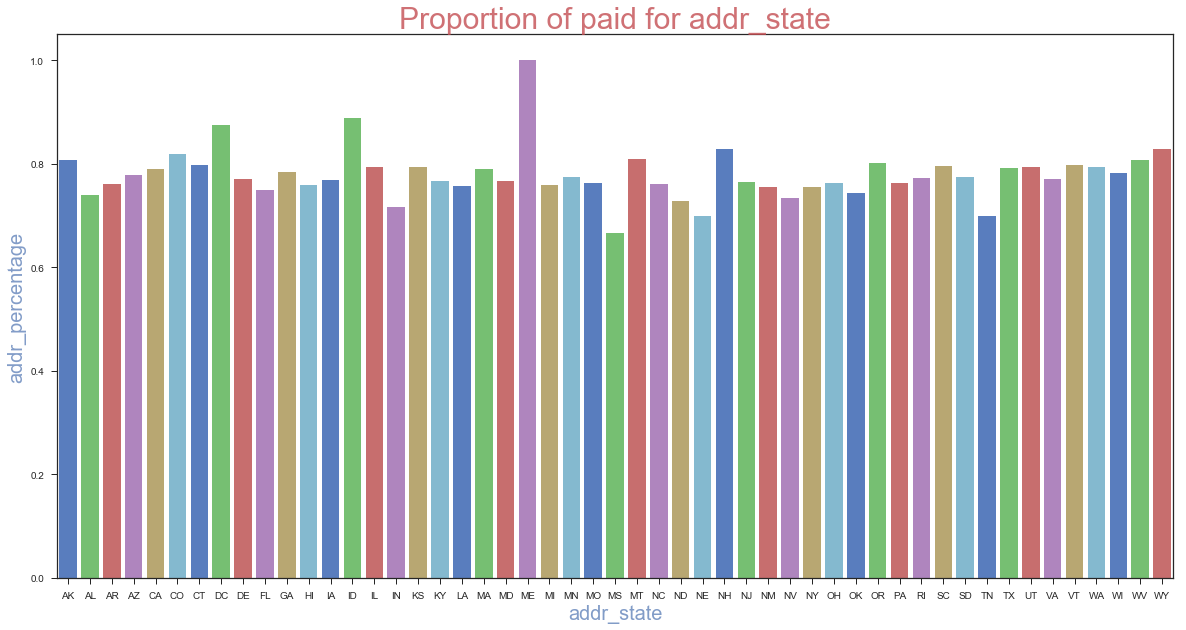

In [435]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set_style("darkgrid")

bar_plot = sns.barplot(x=loan_check['addr_state'],y=loan_check['addr_percentage'], 
                        palette="muted",
                        )

bar_plot.axes.set_title('Proportion of paid for addr_state', fontsize=30,color="r",alpha=0.8)

bar_plot.set_xlabel("addr_state",size = 20,color="b",alpha=0.7)
bar_plot.set_ylabel("addr_percentage",size = 20,color="b",alpha=0.7)

plt.show()

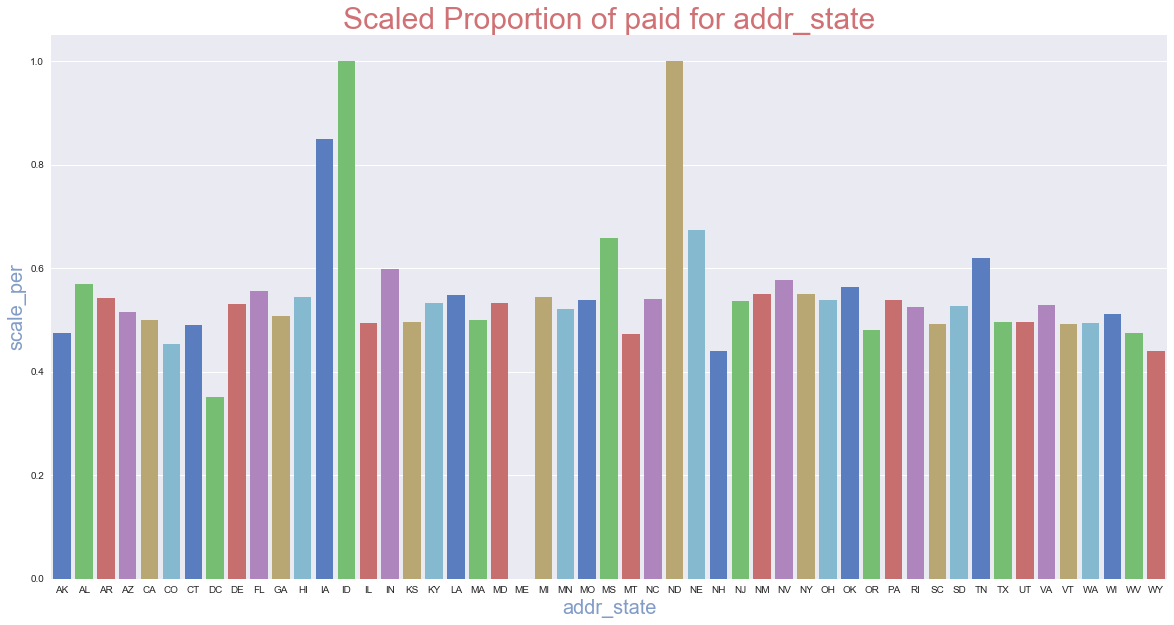

In [436]:
f, ax = plt.subplots(figsize=(20, 10))
sns.set_style("darkgrid")
bar_plot = sns.barplot(x=loan_check_scaled['addr_state'],y=loan_check_scaled['scale_per'],
                        palette="muted",
                        )


bar_plot.axes.set_title('Scaled Proportion of paid for addr_state', fontsize=30,color="r",alpha=0.8)

bar_plot.set_xlabel("addr_state",size = 20,color="b",alpha=0.7)
bar_plot.set_ylabel("scale_per",size = 20,color="b",alpha=0.7)

plt.show()

In [437]:
loan.addr_state.unique()

array(['AZ', 'GA', 'IL', 'CA', 'TX', 'VA', 'MO', 'CT', 'UT', 'FL', 'NY',
       'PA', 'MN', 'NJ', 'OR', 'KY', 'OH', 'SC', 'RI', 'LA', 'MA', 'WA',
       'WI', 'AL', 'NV', 'AK', 'CO', 'MD', 'WV', 'VT', 'MI', 'DC', 'SD',
       'NC', 'AR', 'NM', 'KS', 'HI', 'OK', 'MT', 'WY', 'NH', 'DE', 'MS',
       'TN', 'IA', 'NE', 'ID', 'IN', 'ME', 'ND'], dtype=object)

In [438]:
# 지역 카테고리 대신 정규화된 값에서 나온 가중치를 준다
loan['addr_state'] = loan['addr_state'].replace({'AZ':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='AK'].values,
                                                 'MO':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='MO'].values,
                                                'GA':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='GA'].values ,
                                                'IL': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='IL'].values,
                                                'CA': loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='CA'].values,
                                                'TX':loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='TX'].values,
                                                'VA':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='VA'].values,
                                                'CT':loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='CT'].values,
                                                'UT':loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='UT'].values,
                                                'FL': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='FL'].values,
                                                'NY':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='NY'].values,
                                                'PA': loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='PA'].values,
                                                'MN':loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='MN'].values,
                                                'NJ':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='NJ'].values,
                                                'OR': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='OR'].values,
                                                'KY': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='KY'].values,
                                                'OH': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='OH'].values,
                                                'SC': loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='SC'].values,
                                                'RI': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='RI'].values,
                                                'LA': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='LA'].values,
                                                'MA':loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='MA'].values,
                                                'WA': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='WA'].values,
                                                'WI': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='WI'].values,
                                                'AL':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='AL'].values,
                                                'NV': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='NV'].values,
                                                'AK': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='AK'].values,
                                                'CO': loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='CO'].values,
                                                'MD':loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='MD'].values,
                                                'WV': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='WV'].values,
                                                'VT': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='VT'].values,
                                                'MI': loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='MI'].values,
                                                'DC': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='DC'].values,
                                                'SD':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='SD'].values,
                                                'NC': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='NC'].values,
                                                'AR': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='AR'].values,
                                                'NM': loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='NM'].values,
                                                'KS': loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='KS'].values,
                                                'HI': loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='HI'].values,
                                                'OK':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='OK'].values,
                                                'MT':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='MT'].values,
                                                'WY':loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='WY'].values,
                                                'NH': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='NH'].values,
                                                'DE':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='DE'].values,
                                                'MS': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='MS'].values,
                                                'TN': loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='TN'].values,
                                                'IA':loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='IA'].values,
                                                'NE':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='NE'].values,
                                                'ID': loan_check_scaled['scale_per'][loan_check_scaled.addr_state=='ID'].values,
                                                'IN':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='IN'].values,
                                                'ME':loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='ME'].values,
                                                'ND': loan_check_scaled['scale_per'][loan_check_scaled.addr_state =='ND'].values})
loan.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,home_ANY,home_MORTGAGE,home_NONE,home_OTHER,home_OWN,home_RENT,home_score,source_Not Verified,source_Source Verified,source_Verified
270882,36743377,4200.0,4200.0,4200.0,0.813,15.99,147.64,0.678571,0.688546,supervisor,...,0,1,0,0,0,0,0.797737,0,0,1
270883,36231718,10775.0,10775.0,10775.0,0.813,6.03,327.95,0.923422,0.961649,Coordinator of RSVP,...,0,0,0,0,0,1,0.749271,1,0,0
270884,36241316,6225.0,6225.0,6225.0,0.813,16.49,220.37,0.678571,0.688722,Painter,...,0,0,0,0,0,1,0.749271,0,1,0
270885,36421485,4000.0,4000.0,4000.0,0.813,8.67,126.59,0.845428,0.875421,Lead Custodian,...,0,1,0,0,0,0,0.797737,0,0,1
270886,36260758,10850.0,10850.0,10850.0,0.813,19.24,399.04,0.600912,0.601834,0,...,0,0,0,0,1,0,0.761893,0,0,1


In [439]:
print (loan.addr_state.isnull().value_counts())
print (loan.shape)


False    270887
Name: addr_state, dtype: int64
(270887, 83)


In [440]:
#메모리 정리
del loan_check, loan_check_scaled
gc.collect()

56279

In [441]:
#우편번호는 삭제한다
loan.drop('zip_code',axis = 1,  inplace = True)

## 1-9) initial_list_status
* The initial listing status of the loan. Possible values are – W, F
* 대출초기상태


In [442]:
print (loan.initial_list_status.value_counts())

f    192999
w     77888
Name: initial_list_status, dtype: int64


In [443]:
# one-hot-encoding
loan_check= pd.get_dummies(loan['initial_list_status'], prefix='initial')
loan = loan.join(loan_check)
loan.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,home_NONE,home_OTHER,home_OWN,home_RENT,home_score,source_Not Verified,source_Source Verified,source_Verified,initial_f,initial_w
270882,36743377,4200.0,4200.0,4200.0,0.813,15.99,147.64,0.678571,0.688546,supervisor,...,0,0,0,0,0.797737,0,0,1,1,0
270883,36231718,10775.0,10775.0,10775.0,0.813,6.03,327.95,0.923422,0.961649,Coordinator of RSVP,...,0,0,0,1,0.749271,1,0,0,0,1
270884,36241316,6225.0,6225.0,6225.0,0.813,16.49,220.37,0.678571,0.688722,Painter,...,0,0,0,1,0.749271,0,1,0,1,0
270885,36421485,4000.0,4000.0,4000.0,0.813,8.67,126.59,0.845428,0.875421,Lead Custodian,...,0,0,0,0,0.797737,0,0,1,1,0
270886,36260758,10850.0,10850.0,10850.0,0.813,19.24,399.04,0.600912,0.601834,0,...,0,0,1,0,0.761893,0,0,1,1,0


In [444]:
loan.drop('initial_list_status', axis = 1, inplace = True)

## 1-10) policy_code
* publicly available policy_code=1 공개적으로 사용가능한 정책
* new products not publicly available policy_code=2 새로운, 하지만 공개적으로 사용할 수 없는 정책

In [445]:
loan.policy_code.value_counts()


1.0    270887
Name: policy_code, dtype: int64

In [446]:
# 의미없는 변수이므로 제거한다
loan.drop('policy_code', axis = 1, inplace = True)

## 1-11) application_type
* Indicates whether the loan is an individual application or a joint application with two co-borrowers
* 대출이 차주의 개별신청인지 공동차용인과의 공동신청인지

In [447]:
loan.application_type.value_counts()

INDIVIDUAL    270884
JOINT              3
Name: application_type, dtype: int64

In [448]:
#의미없는 변수로 가정, 삭제한다.
loan.drop('application_type', axis = 1, inplace = True)

In [449]:
#공동차용인이 무의미하다는 것을 확인하고 'joint'가 있는 다른 변수도 확인
# 'annual_inc_joint','dti_joint','verification_status_joint',
print (loan.annual_inc_joint.value_counts())
print (loan.dti_joint.value_counts())
print (loan.verification_status_joint.value_counts())


# 세 변수 다 삭제하기로 한다

loan.drop('annual_inc_joint', axis = 1, inplace = True)
loan.drop('dti_joint', axis = 1, inplace = True)
loan.drop('verification_status_joint', axis = 1, inplace = True)

0.0         270884
108000.0         1
104800.0         1
36000.0          1
Name: annual_inc_joint, dtype: int64
0.00     270884
16.34         1
17.60         1
11.08         1
Name: dti_joint, dtype: int64
0                  270884
Not Verified            1
Verified                1
Source Verified         1
Name: verification_status_joint, dtype: int64


In [450]:
# 중간 null 점검
loan.isnull().sum()

id                        0
loan_amnt                 0
funded_amnt               0
funded_amnt_inv           0
term                      0
int_rate                  0
installment               0
grade                     0
grade_score               0
emp_title                 0
emp_length                0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
desc                      0
purpose                   0
title                     0
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
mths_since_last_delinq    0
mths_since_last_record    0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util                0
total_acc                 0
                         ..
open_acc_6m               0
open_il_6m                0
open_il_12m               0
open_il_24m               0
mths_since_rcnt_il  

## 1-12) issue_d & earliest_cr_line
* 대출을 받는 시점으로부터 신용거래 기간에 따른 상환율을 본다
* 기간 계산 : earliest_cr_line ((year * 12) + month) - issue_d((year * 12) + month) 


In [451]:
loan[['issue_d', 'earliest_cr_line']].tail()

,issue_d,earliest_cr_line
270882,Jan-2015,Aug-1990
270883,Jan-2015,Nov-1975
270884,Jan-2015,Feb-2011
270885,Jan-2015,Sep-2002
270886,Jan-2015,Jun-2002


In [452]:
# issue_d 변형 

loan_d_list = loan['issue_d'].str.split('-').tolist()  # 대출 시작일

for i in range(0, len(loan_d_list)):
    if loan_d_list[i][0] == 'Jan':
        loan_d_list[i][0] = '01'
    elif loan_d_list[i][0] == 'Feb':
        loan_d_list[i][0] = '02'
    elif loan_d_list[i][0] == 'Mar':
        loan_d_list[i][0] = '03'
    elif loan_d_list[i][0] == 'Apr':
        loan_d_list[i][0] = '04'
    elif loan_d_list[i][0] == 'May':
        loan_d_list[i][0] = '05'
    elif loan_d_list[i][0] == 'Jun':
        loan_d_list[i][0] = '06'
    elif loan_d_list[i][0] == 'Jul':
        loan_d_list[i][0] = '07'
    elif loan_d_list[i][0] == 'Aug':
        loan_d_list[i][0] = '08'
    elif loan_d_list[i][0] == 'Sep':
        loan_d_list[i][0] = '09'
    elif loan_d_list[i][0] == 'Oct':
        loan_d_list[i][0] = '10'
    elif loan_d_list[i][0] == 'Nov':
        loan_d_list[i][0] = '11'
    elif loan_d_list[i][0] == 'Dec':
        loan_d_list[i][0] = '12'
    
    a = int(loan_d_list[i][0])  # year 와 month의 위치를 바꾼다
    loan_d_list[i][0] = int(loan_d_list[i][1]) * 12
    loan_d_list[i][1] = a
    loan_d_list[i] = loan_d_list[i][0] + loan_d_list[i][1]

    
loan_check = pd.DataFrame(loan_d_list)
loan_check.rename(columns= {0 : 'issue_d'}, inplace = True)
loan_check.tail()

,issue_d
270882,24181
270883,24181
270884,24181
270885,24181
270886,24181


In [453]:
# earliest_cr_line 변형 

loan_d_list = loan['earliest_cr_line'].str.split('-').tolist()  # 최초 신용거래 시작일

for i in range(0, len(loan_d_list)):
    if loan_d_list[i][0] == 'Jan':
        loan_d_list[i][0] = '01'
    elif loan_d_list[i][0] == 'Feb':
        loan_d_list[i][0] = '02'
    elif loan_d_list[i][0] == 'Mar':
        loan_d_list[i][0] = '03'
    elif loan_d_list[i][0] == 'Apr':
        loan_d_list[i][0] = '04'
    elif loan_d_list[i][0] == 'May':
        loan_d_list[i][0] = '05'
    elif loan_d_list[i][0] == 'Jun':
        loan_d_list[i][0] = '06'
    elif loan_d_list[i][0] == 'Jul':
        loan_d_list[i][0] = '07'
    elif loan_d_list[i][0] == 'Aug':
        loan_d_list[i][0] = '08'
    elif loan_d_list[i][0] == 'Sep':
        loan_d_list[i][0] = '09'
    elif loan_d_list[i][0] == 'Oct':
        loan_d_list[i][0] = '10'
    elif loan_d_list[i][0] == 'Nov':
        loan_d_list[i][0] = '11'
    elif loan_d_list[i][0] == 'Dec':
        loan_d_list[i][0] = '12'
    
    a = int(loan_d_list[i][0])  # year 와 month의 위치를 바꾼다
    loan_d_list[i][0] = int(loan_d_list[i][1]) * 12
    loan_d_list[i][1] = a
    loan_d_list[i] = loan_d_list[i][0] + loan_d_list[i][1]
    

    
loan_check['earliest_cr_line'] = pd.DataFrame(loan_d_list)
#loan_check.rename(columns= {0 : 'issue_d'}, inplace = True)
loan_check.tail()

,issue_d,earliest_cr_line
270882,24181,23888
270883,24181,23711
270884,24181,24134
270885,24181,24033
270886,24181,24030


In [454]:
# 대출결정일 - 최초신용거래일 = 신용거래 기간을 변수로 한다

loan_check['credit_period'] = loan_check.issue_d - loan_check.earliest_cr_line
loan_check.tail()

,issue_d,earliest_cr_line,credit_period
270882,24181,23888,293
270883,24181,23711,470
270884,24181,24134,47
270885,24181,24033,148
270886,24181,24030,151


In [455]:
loan['credit_period'] = loan_check['credit_period']
loan.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,home_OTHER,home_OWN,home_RENT,home_score,source_Not Verified,source_Source Verified,source_Verified,initial_f,initial_w,credit_period
270882,36743377,4200.0,4200.0,4200.0,0.813,15.99,147.64,0.678571,0.688546,supervisor,...,0,0,0,0.797737,0,0,1,1,0,293
270883,36231718,10775.0,10775.0,10775.0,0.813,6.03,327.95,0.923422,0.961649,Coordinator of RSVP,...,0,0,1,0.749271,1,0,0,0,1,470
270884,36241316,6225.0,6225.0,6225.0,0.813,16.49,220.37,0.678571,0.688722,Painter,...,0,0,1,0.749271,0,1,0,1,0,47
270885,36421485,4000.0,4000.0,4000.0,0.813,8.67,126.59,0.845428,0.875421,Lead Custodian,...,0,0,0,0.797737,0,0,1,1,0,148
270886,36260758,10850.0,10850.0,10850.0,0.813,19.24,399.04,0.600912,0.601834,0,...,0,1,0,0.761893,0,0,1,1,0,151


In [456]:
print (loan.credit_period.isnull().value_counts())

False    270887
Name: credit_period, dtype: int64


## 1-13) last_pymnt_d & last_credit_pull_d


### 1) last_pymnt_d
* issue_d 와의 차이를 구하여 상환 기간을 구한다 

In [457]:
# last_pymnt_d 변형 

loan_d_list = loan['last_pymnt_d'].str.split('-').tolist()  # 최초 신용거래 시작일

for i in range(0, len(loan_d_list)):
    if loan_d_list[i][0] == 'Jan':
        loan_d_list[i][0] = '01'
    elif loan_d_list[i][0] == 'Feb':
        loan_d_list[i][0] = '02'
    elif loan_d_list[i][0] == 'Mar':
        loan_d_list[i][0] = '03'
    elif loan_d_list[i][0] == 'Apr':
        loan_d_list[i][0] = '04'
    elif loan_d_list[i][0] == 'May':
        loan_d_list[i][0] = '05'
    elif loan_d_list[i][0] == 'Jun':
        loan_d_list[i][0] = '06'
    elif loan_d_list[i][0] == 'Jul':
        loan_d_list[i][0] = '07'
    elif loan_d_list[i][0] == 'Aug':
        loan_d_list[i][0] = '08'
    elif loan_d_list[i][0] == 'Sep':
        loan_d_list[i][0] = '09'
    elif loan_d_list[i][0] == 'Oct':
        loan_d_list[i][0] = '10'
    elif loan_d_list[i][0] == 'Nov':
        loan_d_list[i][0] = '11'
    elif loan_d_list[i][0] == 'Dec':
        loan_d_list[i][0] = '12'
    
    a = int(loan_d_list[i][0])  # year 와 month의 위치를 바꾼다
    loan_d_list[i][0] = int(loan_d_list[i][1]) * 12
    loan_d_list[i][1] = a
    loan_d_list[i] = loan_d_list[i][0] + loan_d_list[i][1]
    

    
loan_check['last_pymnt_d'] = pd.DataFrame(loan_d_list)
loan_check['pymnt_period'] = loan_check.last_pymnt_d - loan_check.issue_d
loan_check.tail()

,issue_d,earliest_cr_line,credit_period,last_pymnt_d,pymnt_period
270882,24181,23888,293,24188,7
270883,24181,23711,470,24187,6
270884,24181,24134,47,24192,11
270885,24181,24033,148,24186,5
270886,24181,24030,151,24188,7


### 2) last_credit_pull_d
* issue_d 와의 차이로 신용등급이 조회된 기간을 구한다.(새로이 신용등급이 조회 되었다는 것은 추가 대출을 알아봤다는 가능성)

In [458]:
# last_credit_pull_d 변형 

loan_d_list = loan['last_credit_pull_d'].str.split('-').tolist()  # 최초 신용거래 시작일

for i in range(0, len(loan_d_list)):
    if loan_d_list[i][0] == 'Jan':
        loan_d_list[i][0] = '01'
    elif loan_d_list[i][0] == 'Feb':
        loan_d_list[i][0] = '02'
    elif loan_d_list[i][0] == 'Mar':
        loan_d_list[i][0] = '03'
    elif loan_d_list[i][0] == 'Apr':
        loan_d_list[i][0] = '04'
    elif loan_d_list[i][0] == 'May':
        loan_d_list[i][0] = '05'
    elif loan_d_list[i][0] == 'Jun':
        loan_d_list[i][0] = '06'
    elif loan_d_list[i][0] == 'Jul':
        loan_d_list[i][0] = '07'
    elif loan_d_list[i][0] == 'Aug':
        loan_d_list[i][0] = '08'
    elif loan_d_list[i][0] == 'Sep':
        loan_d_list[i][0] = '09'
    elif loan_d_list[i][0] == 'Oct':
        loan_d_list[i][0] = '10'
    elif loan_d_list[i][0] == 'Nov':
        loan_d_list[i][0] = '11'
    elif loan_d_list[i][0] == 'Dec':
        loan_d_list[i][0] = '12'
    
    a = int(loan_d_list[i][0])  # year 와 month의 위치를 바꾼다
    loan_d_list[i][0] = int(loan_d_list[i][1]) * 12
    loan_d_list[i][1] = a
    loan_d_list[i] = loan_d_list[i][0] + loan_d_list[i][1]
    

    
loan_check['last_credit_pull_d'] = pd.DataFrame(loan_d_list)
loan_check['crd_pull_period'] = loan_check.last_credit_pull_d - loan_check.issue_d
loan_check.tail()

,issue_d,earliest_cr_line,credit_period,last_pymnt_d,pymnt_period,last_credit_pull_d,crd_pull_period
270882,24181,23888,293,24188,7,24193,12
270883,24181,23711,470,24187,6,24186,5
270884,24181,24134,47,24192,11,24192,11
270885,24181,24033,148,24186,5,24191,10
270886,24181,24030,151,24188,7,24193,12


In [459]:
loan['pymnt_period'] = loan_check['pymnt_period']
loan['crd_pull_period'] = loan_check['crd_pull_period']
loan.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,home_RENT,home_score,source_Not Verified,source_Source Verified,source_Verified,initial_f,initial_w,credit_period,pymnt_period,crd_pull_period
270882,36743377,4200.0,4200.0,4200.0,0.813,15.99,147.64,0.678571,0.688546,supervisor,...,0,0.797737,0,0,1,1,0,293,7,12
270883,36231718,10775.0,10775.0,10775.0,0.813,6.03,327.95,0.923422,0.961649,Coordinator of RSVP,...,1,0.749271,1,0,0,0,1,470,6,5
270884,36241316,6225.0,6225.0,6225.0,0.813,16.49,220.37,0.678571,0.688722,Painter,...,1,0.749271,0,1,0,1,0,47,11,11
270885,36421485,4000.0,4000.0,4000.0,0.813,8.67,126.59,0.845428,0.875421,Lead Custodian,...,0,0.797737,0,0,1,1,0,148,5,10
270886,36260758,10850.0,10850.0,10850.0,0.813,19.24,399.04,0.600912,0.601834,0,...,0,0.761893,0,0,1,1,0,151,7,12


In [460]:
# 혹시나 모를 nan 값 확인
loan.isnull().sum()

id                        0
loan_amnt                 0
funded_amnt               0
funded_amnt_inv           0
term                      0
int_rate                  0
installment               0
grade                     0
grade_score               0
emp_title                 0
emp_length                0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
desc                      0
purpose                   0
title                     0
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
mths_since_last_delinq    0
mths_since_last_record    0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util                0
total_acc                 0
                         ..
open_il_24m               0
mths_since_rcnt_il        0
total_bal_il              0
il_util                   0
open_rv_12m         

In [461]:
# 메모리 정리
del loan_check
gc.collect()

48

## 1-14) next_pymnt_d

In [462]:

# 돌아오는 상환날은 대출 부실여부를 판단하는 변수로는 부적합하다고 판단, 삭제 한다.
loan.drop('next_pymnt_d', axis=1, inplace=True)

## 1-15) desc
* 주관적으로 대출에 대해 설명 해 놓은 것으로 유,무에 따라 상환,부실에 차이가 있나 확인 해 본다

In [463]:
loan_check = loan['desc'][:]
loan_check = pd.DataFrame(loan_check)
loan_check.rename(columns={'desc':'check_desc'}, inplace=True)
loan_check.head()

,check_desc
0,Borrower added on 12/22/11 > I need to upgra...
1,Borrower added on 12/22/11 > I plan to use t...
2,0
3,Borrower added on 12/21/11 > to pay for prop...
4,0


In [464]:
# last_credit_pull_d 변형 

loan_desc_list = loan_check['check_desc'].tolist()  # 최초 신용거래 시작일


for i in range(0, len(loan_desc_list)):

    if loan_desc_list[i] != 0:
        loan_desc_list[i] = 1

        
loan['check_desc'] = loan_desc_list    

loan.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,home_score,source_Not Verified,source_Source Verified,source_Verified,initial_f,initial_w,credit_period,pymnt_period,crd_pull_period,check_desc
0,1077501,5000.0,5000.0,4975.0,0.813,10.65,162.87,0.845428,0.864213,0,...,0.749271,0,0,1,1,0,323,37,49,1
1,1077430,2500.0,2500.0,2500.0,0.645,15.27,59.83,0.755894,0.730623,Ryder,...,0.749271,0,1,0,1,0,152,16,21,1
2,1077175,2400.0,2400.0,2400.0,0.813,15.96,84.33,0.755894,0.718686,0,...,0.749271,1,0,0,1,0,121,30,49,0
3,1076863,10000.0,10000.0,10000.0,0.813,13.49,339.31,0.755894,0.791940,AIR RESOURCES BOARD,...,0.749271,0,1,0,1,0,190,37,37,1
4,1075269,5000.0,5000.0,5000.0,0.813,7.90,156.46,0.923422,0.917008,Veolia Transportaton,...,0.749271,0,1,0,1,0,85,37,45,0


In [465]:
#대출 설명이 있는가 없는가에 따른 상환비율을 확인
loan_check = loan[['check_desc', 'loan_status']]
loan_check.tail()

,check_desc,loan_status
270882,0,1
270883,0,0
270884,0,0
270885,0,0
270886,0,1


In [466]:

loan_check_temp = pd.DataFrame(loan_check.groupby(['check_desc', 'loan_status']).size())

loan_check_temp.reset_index(inplace=True)
loan_check_temp = loan_check_temp.pivot('check_desc', 'loan_status', 0)

loan_check_temp


loan_status,0,1
check_desc,,
0,134808,43930
1,74903,17246


In [467]:
loan_check_temp.reset_index(inplace = True)

loan_check_temp.rename(columns={0:'paid', 1:'default'}, inplace = True)
loan_check_temp.check_desc.replace({0:'non-desc', 1:'desc'}, inplace = True)

loan_check_temp


loan_status,check_desc,paid,default
0,non-desc,134808,43930
1,desc,74903,17246


In [468]:
#대출설명 유무에 따른 상환비율
loan_check_temp['proportion'] = loan_check_temp.paid/(loan_check_temp.paid + loan_check_temp.default)
loan_check_temp

loan_status,check_desc,paid,default,proportion
0,non-desc,134808,43930,0.754221
1,desc,74903,17246,0.812847


In [469]:
loan['check_desc']=loan.check_desc.replace({0:0.754, 1:0.813})
loan.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,home_score,source_Not Verified,source_Source Verified,source_Verified,initial_f,initial_w,credit_period,pymnt_period,crd_pull_period,check_desc
270882,36743377,4200.0,4200.0,4200.0,0.813,15.99,147.64,0.678571,0.688546,supervisor,...,0.797737,0,0,1,1,0,293,7,12,0.754
270883,36231718,10775.0,10775.0,10775.0,0.813,6.03,327.95,0.923422,0.961649,Coordinator of RSVP,...,0.749271,1,0,0,0,1,470,6,5,0.754
270884,36241316,6225.0,6225.0,6225.0,0.813,16.49,220.37,0.678571,0.688722,Painter,...,0.749271,0,1,0,1,0,47,11,11,0.754
270885,36421485,4000.0,4000.0,4000.0,0.813,8.67,126.59,0.845428,0.875421,Lead Custodian,...,0.797737,0,0,1,1,0,148,5,10,0.754
270886,36260758,10850.0,10850.0,10850.0,0.813,19.24,399.04,0.600912,0.601834,0,...,0.761893,0,0,1,1,0,151,7,12,0.754


In [470]:
loan.drop('desc', axis = 1, inplace = True)

In [471]:
print(loan.shape)

(270887, 80)


## 1-16) purpose 
* 목적 분류에 따른 대출 상환 비율을 확인 해 본다

In [472]:
loan.purpose.value_counts()

debt_consolidation    159182
credit_card            53126
home_improvement       15989
other                  15497
major_purchase          6660
small_business          5166
car                     3805
medical                 3069
moving                  2198
wedding                 2019
house                   1779
vacation                1696
educational              422
renewable_energy         279
Name: purpose, dtype: int64

In [473]:
loan_check = loan[['purpose', 'loan_status']]
loan_check = loan_check.groupby(['purpose', 'loan_status']).size()
loan_check = pd.DataFrame(loan_check)
loan_check

0
purpose            loan_status        
car                0              3249
                   1               556
credit_card        0             42521
                   1             10605
debt_consolidation 0            121572
                   1             37610
educational        0               334
                   1                88
home_improvement   0             12803
                   1              3186
house              0              1399
                   1               380
major_purchase     0              5491
                   1              1169
medical            0              2321
                   1               748
moving             0              1634
                   1               564
other              0             11644
                   1              3853
renewable_energy   0               215
                   1                64
small_business     0              3464
                   1              1702
vacation           0              1331
                   1               365
wedding            0              1733
                   1               286

In [474]:
loan_check.reset_index(inplace = True)
loan_check = loan_check.pivot('purpose', 'loan_status',0)
#loan_check.reset_index(inplace = True)
loan_check

loan_status,0,1
purpose,,
car,3249,556
credit_card,42521,10605
debt_consolidation,121572,37610
educational,334,88
home_improvement,12803,3186
house,1399,380
major_purchase,5491,1169
medical,2321,748
moving,1634,564


In [475]:
loan_check = loan_check.reset_index().rename(columns = {0:'paid', 1:'default'})
loan_check


loan_status,purpose,paid,default
0,car,3249,556
1,credit_card,42521,10605
2,debt_consolidation,121572,37610
3,educational,334,88
4,home_improvement,12803,3186
5,house,1399,380
6,major_purchase,5491,1169
7,medical,2321,748
8,moving,1634,564
9,other,11644,3853


In [476]:
loan_check['pur_pro'] = loan_check.paid / (loan_check.paid + loan_check.default)
loan_check

loan_status,purpose,paid,default,pur_pro
0,car,3249,556,0.853876
1,credit_card,42521,10605,0.800380
2,debt_consolidation,121572,37610,0.763730
3,educational,334,88,0.791469
4,home_improvement,12803,3186,0.800738
5,house,1399,380,0.786397
6,major_purchase,5491,1169,0.824474
7,medical,2321,748,0.756272
8,moving,1634,564,0.743403
9,other,11644,3853,0.751371


In [477]:
loan['purpose'] = loan['purpose'].replace({'debt_consolidation':loan_check['pur_pro'][loan_check.purpose =='debt_consolidation'].values,
                                           'credit_card':loan_check['pur_pro'][loan_check.purpose =='credit_card'].values,
                                            'home_improvement':loan_check['pur_pro'][loan_check.purpose =='home_improvement'].values,
                                            'other':loan_check['pur_pro'][loan_check.purpose == 'other'].values,           
                                            'major_purchase':loan_check['pur_pro'][loan_check.purpose =='major_purchase'].values,  
                                            'small_business': loan_check['pur_pro'][loan_check.purpose =='small_business'].values, 
                                            'car':loan_check['pur_pro'][loan_check.purpose =='car'].values,             
                                            'medical':loan_check['pur_pro'][loan_check.purpose =='medical'].values,         
                                            'moving':loan_check['pur_pro'][loan_check.purpose =='moving'].values,          
                                            'wedding':loan_check['pur_pro'][loan_check.purpose =='wedding'].values,         
                                            'house':loan_check['pur_pro'][loan_check.purpose =='house'].values,           
                                            'vacation':loan_check['pur_pro'][loan_check.purpose =='vacation'].values,        
                                            'educational':loan_check['pur_pro'][loan_check.purpose =='educational'].values,     
                                            'renewable_energy':loan_check['pur_pro'][loan_check.purpose =='renewable_energy'].values})

In [478]:
del loan_check
gc.collect()

124

## 1-17) title 
* purpose의 세부내역으로 보이므로 삭제한다

In [479]:
loan.title.value_counts()

Debt consolidation                          80476
Credit card refinancing                     25082
Debt Consolidation                          11331
Home improvement                             7464
Other                                        6723
Consolidation                                3658
debt consolidation                           3315
Debt Consolidation Loan                      3112
Major purchase                               2409
Business                                     1984
Personal Loan                                1676
Credit Card Consolidation                    1657
Medical expenses                             1513
consolidation                                1423
Home Improvement                             1275
Consolidation Loan                           1226
Car financing                                1059
Credit Card Refinance                         991
Vacation                                      943
Moving and relocation                         922


In [480]:
loan.drop('title', axis=1, inplace=True)

## 1-18) issue_d

In [481]:
loan.issue_d

0         Dec-2011
1         Dec-2011
2         Dec-2011
3         Dec-2011
4         Dec-2011
5         Dec-2011
6         Dec-2011
7         Dec-2011
8         Dec-2011
9         Dec-2011
10        Dec-2011
11        Dec-2011
12        Dec-2011
13        Dec-2011
14        Dec-2011
15        Dec-2011
16        Dec-2011
17        Dec-2011
18        Dec-2011
19        Dec-2011
20        Dec-2011
21        Dec-2011
22        Dec-2011
23        Dec-2011
24        Dec-2011
25        Dec-2011
26        Dec-2011
27        Dec-2011
28        Dec-2011
29        Dec-2011
            ...   
270857    Jan-2015
270858    Jan-2015
270859    Jan-2015
270860    Jan-2015
270861    Jan-2015
270862    Jan-2015
270863    Jan-2015
270864    Jan-2015
270865    Jan-2015
270866    Jan-2015
270867    Jan-2015
270868    Jan-2015
270869    Jan-2015
270870    Jan-2015
270871    Jan-2015
270872    Jan-2015
270873    Jan-2015
270874    Jan-2015
270875    Jan-2015
270876    Jan-2015
270877    Jan-2015
270878    Ja

In [482]:
loan_d_list = loan['issue_d'].str.split('-').tolist()  # 대출 시작일

for i in range(0, len(loan_d_list)):
    loan_d_list[i][1] = 0

    
loan_check = pd.DataFrame(loan_d_list)


In [483]:
loan['issue_month'] = loan_check[0]

In [484]:
loan_check = loan[['issue_month', 'loan_status']]
loan_check = pd.DataFrame(loan_check.groupby(['issue_month', 'loan_status']).size()).reset_index().\
pivot('issue_month', 'loan_status', 0).reset_index().rename(columns = {0:'paid', 1:'default'})

In [485]:
loan_check['month_pro'] = loan_check.paid / (loan_check.paid + loan_check.default)
loan_check

loan_status,issue_month,paid,default,month_pro
0,Apr,17623,5469,0.763165
1,Aug,17759,4916,0.783197
2,Dec,15485,3787,0.803497
3,Feb,14870,4563,0.765193
4,Jan,18600,5399,0.775032
5,Jul,20372,6343,0.762568
6,Jun,16282,5054,0.763123
7,Mar,15982,4724,0.771854
8,May,17017,5389,0.759484
9,Nov,18266,5039,0.783780


In [486]:
loan['month_score'] = loan['issue_month'].replace({'Jan':loan_check['month_pro'][loan_check['issue_month'] =='Jan'].values,
                                                   'Feb':loan_check['month_pro'][loan_check['issue_month'] =='Feb'].values,
                                                   'Mar':loan_check['month_pro'][loan_check['issue_month'] =='Mar'].values,
                                                   'Apr':loan_check['month_pro'][loan_check['issue_month'] =='Apr'].values,
                                                   'May':loan_check['month_pro'][loan_check['issue_month'] =='May'].values,
                                                   'Jun':loan_check['month_pro'][loan_check['issue_month'] =='Jun'].values,
                                                   'Jul':loan_check['month_pro'][loan_check['issue_month'] =='Jul'].values,
                                                   'Aug':loan_check['month_pro'][loan_check['issue_month'] =='Aug'].values,
                                                   'Sep':loan_check['month_pro'][loan_check['issue_month'] =='Sep'].values,
                                                   'Oct':loan_check['month_pro'][loan_check['issue_month'] =='Oct'].values,
                                                   'Nov':loan_check['month_pro'][loan_check['issue_month'] =='Nov'].values,
                                                  'Dec':loan_check['month_pro'][loan_check['issue_month'] =='Dec'].values})
        
loan.month_score.value_counts() 



0.773362    27855
0.762568    26715
0.775032    23999
0.783780    23305
0.763165    23092
0.783197    22675
0.759484    22406
0.763123    21336
0.771854    20706
0.791967    20093
0.765193    19433
0.803497    19272
Name: month_score, dtype: int64

In [487]:
loan.drop('issue_month', axis = 1, inplace = True)

del loan_check


# one-hot-encoding
#loan_check= pd.get_dummies(loan['issue_month'], prefix='month')
#loan = loan.join(loan_check)
loan.tail()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,grade_score,emp_title,...,source_Not Verified,source_Source Verified,source_Verified,initial_f,initial_w,credit_period,pymnt_period,crd_pull_period,check_desc,month_score
270882,36743377,4200.0,4200.0,4200.0,0.813,15.99,147.64,0.678571,0.688546,supervisor,...,0,0,1,1,0,293,7,12,0.754,0.775032
270883,36231718,10775.0,10775.0,10775.0,0.813,6.03,327.95,0.923422,0.961649,Coordinator of RSVP,...,1,0,0,0,1,470,6,5,0.754,0.775032
270884,36241316,6225.0,6225.0,6225.0,0.813,16.49,220.37,0.678571,0.688722,Painter,...,0,1,0,1,0,47,11,11,0.754,0.775032
270885,36421485,4000.0,4000.0,4000.0,0.813,8.67,126.59,0.845428,0.875421,Lead Custodian,...,0,0,1,1,0,148,5,10,0.754,0.775032
270886,36260758,10850.0,10850.0,10850.0,0.813,19.24,399.04,0.600912,0.601834,0,...,0,0,1,1,0,151,7,12,0.754,0.775032


In [488]:
loan.drop(['emp_title'], axis=1, inplace=True)

## 1-19) 정확한 대출 예측 모델을 만들기 위해, 대출 신청 시점에는 알 수 없는 변수를 삭제한다

*##!!!!! 결과론적인 설명변수

* 'last_pymnt_amnt': 마지막 상환금액
* 'recoveries' : 회수된 청구액
* 'out_prncp' : 미납된 원금
* 'out_prncp_inv' : 미납된 원금비율
* total_rec_prncp : 현재까지 받은 원금 (채권자가)   
* collection_recovery_fee :추심수수료
* total_pymnt: 상환금액
* total_pymnt_inv :상환금액
* total_rec_int :현재까지 받은 이자     
* pymnt_period : 상환기간
* total_rec_late_fee: 연체료
* crd_pull_period 

In [489]:
loan.drop('earliest_cr_line', axis = 1, inplace = True)
loan.drop('last_pymnt_d', axis = 1, inplace = True)
loan.drop('last_credit_pull_d', axis = 1, inplace = True)


In [490]:
deduct = ['last_pymnt_amnt','recoveries', 'out_prncp','out_prncp_inv',
          'total_rec_prncp','collection_recovery_fee','total_pymnt','total_pymnt_inv',
          'total_rec_int','pymnt_period','total_rec_late_fee','crd_pull_period']

In [491]:
loan.drop(deduct, axis=1, inplace=True)

In [492]:
loan.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'grade_score', 'emp_length', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'term_ 36 months', 'term_ 60 months', 'grade_square', 'home_ANY',
       'home_MORTGAGE', 'home_NONE', 'home_OTHER', 'home_OWN', 'home_RENT',
       'home_score', 'source_Not Verified', 'source_Source Verified',


In [493]:
loan.shape

(270887, 64)

# 2. 다음 처리를 위한 pickle변환

In [494]:
import pickle

pickle.dump( loan, open( "loan_preprocess2", "wb" ) )

In [ ]:
# 해당 파일 import

loan = pickle.load( open( "loan_preprocess2", "rb" ) )

# 3.직업 구분을 위한 자연어 처리 (emp_title)


* The job title supplied by the Borrower when applying for the loan.*
* Employer Title replaces Employer Name for all loans listed after 9/23/2013
* 2013.09.23일 이후로는 직업며이 분류가 아니라 고유명사(employer name)이므로 분류에 어려움이 있을 것으로 예측된다

In [ ]:
# 날짜 순서대로 sort를 위해서 issue_d 변형 

loan_d_list = loan['issue_d'].str.split('-').tolist()  # 최초 신용거래 시작일

for i in range(0, len(loan_d_list)):
    if loan_d_list[i][0] == 'Jan':
        loan_d_list[i][0] = '01'
    elif loan_d_list[i][0] == 'Feb':
        loan_d_list[i][0] = '02'
    elif loan_d_list[i][0] == 'Mar':
        loan_d_list[i][0] = '03'
    elif loan_d_list[i][0] == 'Apr':
        loan_d_list[i][0] = '04'
    elif loan_d_list[i][0] == 'May':
        loan_d_list[i][0] = '05'
    elif loan_d_list[i][0] == 'Jun':
        loan_d_list[i][0] = '06'
    elif loan_d_list[i][0] == 'Jul':
        loan_d_list[i][0] = '07'
    elif loan_d_list[i][0] == 'Aug':
        loan_d_list[i][0] = '08'
    elif loan_d_list[i][0] == 'Sep':
        loan_d_list[i][0] = '09'
    elif loan_d_list[i][0] == 'Oct':
        loan_d_list[i][0] = '10'
    elif loan_d_list[i][0] == 'Nov':
        loan_d_list[i][0] = '11'
    elif loan_d_list[i][0] == 'Dec':
        loan_d_list[i][0] = '12'
    
    a = loan_d_list[i][0]  # year 와 month의 위치를 바꾼다
    loan_d_list[i][0] = loan_d_list[i][1]
    loan_d_list[i][1] = a
    loan_d_list[i] = loan_d_list[i][0] + loan_d_list[i][1]
    

    
loan_check = pd.DataFrame(loan_d_list)

loan_check.rename(columns = {0:'issue_d'}, inplace = True)
loan_check.issue_d.astype(int)

loan_check.tail()

In [ ]:
loan['issue_date'] = loan_check['issue_d']
loan.tail()

In [ ]:
loan_check = loan.sort_values('issue_date')
loan_check.reset_index(inplace = True)
loan_check.drop('index', axis = 1, inplace = True)


In [ ]:
loan_check.tail()

In [ ]:
loan_check.loc[loan_check['issue_date'] == '201308']

# index 0~136548 : ~2013년08월
# index 136549 ~ : 2013년 09월
loan_check_temp = loan_check.iloc[:136548]

In [ ]:
loan_check_temp

In [ ]:
loan_check_temp = loan_check_temp[['id', 'emp_title', 'loan_status']]

loan_check_temp.tail()



In [ ]:
loan_check_temp.tail()

## 3-1) making corpus
* 우선 단어 임베딩을 위한 코퍼스를 만든다. 코퍼스는 리스트의 리스트 형태로 구현되어야 한다. 내부 리스트는 하나의 문장을 이루는 단어 열이 된다.

In [ ]:
#리스트 중 0 을 제외한 값을 뽑아낸다

loan_check_list = loan_check_temp[['emp_title', 'loan_status']].values.tolist()

emp_corpus = [] # 직업
status_list = [] # 대출 상환 여부


#from gensim.models.word2vec import Word2Vec
#%%time
#model = Word2Vec(loan_check_list) # 트레이닝

#model.init_sims(replace=True) # 트레이닝이 완료되면 필요없는 메모리는 unload

In [ ]:
model.most_similar(".")